In [16]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import statsmodels.api as stm

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import SplineTransformer
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import validation_curve, GridSearchCV


class PowerTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, exponent=1.0):
        self.exponent = exponent
        
    def fit(self, X, y=None):
        return self            ## no parameters need to be fit - so just return
    
    def transform(self, X):
        return np.power(X, self.exponent)
    
    def inverse_transform(self, X):
        return np.power(X, 1.0 / self.exponent)


def Make_safe_r2_scorer(y):

    avg = np.average(y)
    mean_sumsq = np.average( (y-avg) * (y-avg) ) 
    
    def safe_r2_scorer(estimator, X, y):
        ypred = estimator.predict( X )
        residuals = y - ypred
        resid_sumsq = np.average(residuals * residuals)
        ## Compare residual sum of squares of the data X, y, with the sum of squared 
        ## differences to the mean for the *full* data set.  This makes the r2 values
        ## average out to a sensible value.
        r2 = 1 - resid_sumsq / mean_sumsq
        return r2
        
    ## The returned function has "bound" the variable mean_sumsq, which is now
    ## available whenever someone calls safe_r2_scorer
    return safe_r2_scorer
  

from google.colab import files 
## Upload 'Wednesday.csv' 
files.upload();

Saving Wednesday.csv to Wednesday (1).csv


In [17]:
df = pd.read_csv("Wednesday.csv")
df = df.join(pd.get_dummies(df['Sex'], drop_first = True))

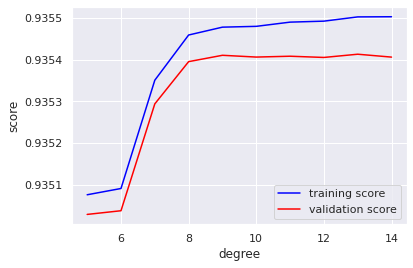

In [18]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

df1 = df.sample(frac=1)
y = df1['txAVD']
X = df1

age_prepro = Pipeline(steps=[('power_tx', PowerTransformer(exponent = 0.5)),
                             ('poly', PolynomialFeatures(degree = 1))])

prepro = ColumnTransformer([('col_age', age_prepro, ["Age"]),
                            ("identity", "passthrough", ["male", "Weight_kg", "Height_cm"])],
                           remainder = "drop")

pipe = Pipeline([('prepro', prepro),
                 ('model', LinearRegression())])

scoremethod = Make_safe_r2_scorer(y)

degrees = np.arange(5,15)
train_score, val_score = validation_curve(pipe, X, y,
                                          param_name = 'prepro__col_age__poly__degree', 
                                          param_range = degrees, 
                                          cv = 15,
                                          scoring = scoremethod)
plt.plot(degrees, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(degrees, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('degree')
plt.ylabel('score');

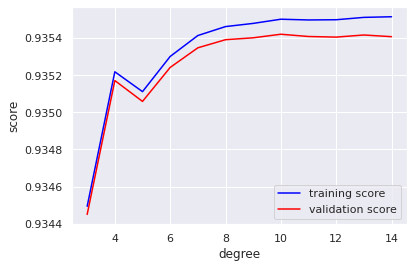

In [19]:
from sklearn.preprocessing import SplineTransformer

age_prepro = Pipeline(steps=[('power_tx', PowerTransformer(exponent = 0.5)),
                            ('spline', SplineTransformer(n_knots=3, degree=3))])

prepro = ColumnTransformer([('col_age', age_prepro, ["Age"]),
                            ("identity", "passthrough", ["male", "Weight_kg", "Height_cm"])],
                           remainder = "drop")

pipe = Pipeline([('prepro', prepro),
                 ('model', LinearRegression())])

knots = np.arange(3,15)
train_score, val_score = validation_curve(pipe, X, y,
                                          param_name = 'prepro__col_age__spline__n_knots', 
                                          param_range = knots, 
                                          cv = 15,
                                          scoring = scoremethod)
plt.plot(knots, np.mean(train_score, 1), color='blue', label='training score')
plt.plot(knots, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('degree')
plt.ylabel('score');

In [20]:
## Now do a more serious grid search over parameter space -- try different power transformations,
## using a 5-knot spline function approximation
## Use 5-fold cross validation to save time (9:25-)

from sklearn.model_selection import GridSearchCV

var_prepro = Pipeline(steps=[('power_tx', PowerTransformer(exponent = 0.5)),
                             ('spline', SplineTransformer(n_knots=5, degree=3))])

prepro = ColumnTransformer([('col_age', var_prepro, ["Age"]),
                            ('col_wt', var_prepro, ["Weight_kg"]),
                            ('col_ht', var_prepro, ["Height_cm"]),
                            ("identity", "passthrough", ["male"])],
                           remainder = "drop")
pipe = Pipeline([('transform', prepro),
                 ('model', LinearRegression())])

param_grid = {'transform__col_age__power_tx__exponent': np.arange(0.05,0.5,0.1),
              'transform__col_wt__power_tx__exponent': np.arange(0.05,0.5,0.1),
              'transform__col_ht__power_tx__exponent': np.arange(0.05,1,0.1)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = scoremethod)  ## This is also a pipeline
grid.fit(X, y)

print("Best score: ",grid.best_score_)

best_exponents = grid.best_params_

Best score:  0.9372772060927657


In [21]:
best_exponents

{'transform__col_age__power_tx__exponent': 0.35000000000000003,
 'transform__col_ht__power_tx__exponent': 0.5500000000000002,
 'transform__col_wt__power_tx__exponent': 0.25000000000000006}

In [22]:
## Similarly, optimize number of spline basis functions (knots)
## This takes a while, so reduce the number of cross-validations to 5

## This takes the keys from the dictionary `best_exponents` and uses them as
## (named) parameters to the function set_params.  It has the effect of
## setting the pipeline's parameters to the best values as found in the
## grid search above.
pipe.set_params(**best_exponents)

param_grid = {'transform__col_age__spline__n_knots': np.arange(5,20,3),
              'transform__col_wt__spline__n_knots': np.arange(5,20,3),
              'transform__col_ht__spline__n_knots': np.arange(5,20,3)}

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = scoremethod)  ## This is also an estimator, so call 'fit'
grid.fit(X, y)

best_splines = grid.best_params_

print("Best score: ",grid.best_score_)
print("Best spline numbers: ",best_splines)

Best score:  0.9374020880411097
Best spline numbers:  {'transform__col_age__spline__n_knots': 14, 'transform__col_ht__spline__n_knots': 11, 'transform__col_wt__spline__n_knots': 11}


In [23]:
## Using polynomials rather than splines gives slightly worse results for slightly more parameters:
## (This takes a few minutes to run)

var_prepro = Pipeline(steps=[('power_tx', PowerTransformer()),
                            ('poly', PolynomialFeatures(1))])

prepro = ColumnTransformer([('col_age', var_prepro, ["Age"]),
                            ('col_wt', var_prepro, ["Weight_kg"]),
                            ('col_ht', var_prepro, ["Height_cm"]),
                            ("identity", "passthrough", ["male"])],
                           remainder = "drop")

pipe = Pipeline([('transform', prepro),
                 ('model', LinearRegression())])

## use pipe.get_params() to inspect parameters

pipe.set_params(**best_exponents)

param_grid = {'transform__col_ht__poly__degree': np.arange(1,10,1),
              'transform__col_wt__poly__degree': np.arange(1,10,1),
              'transform__col_age__poly__degree': np.arange(1,10,1)}

## use pipe.fit(X,y) to test-drive the pipeline, and fix any errors before running validation_curve

grid = GridSearchCV(pipe, param_grid, cv=5, scoring = scoremethod)  ## This is also an estimator
grid.fit(X, y)

best_degrees = grid.best_params_

print("Best score: ",grid.best_score_)
print("Best degrees: ",best_degrees)

Best score:  0.937312684054954
Best degrees:  {'transform__col_age__poly__degree': 9, 'transform__col_ht__poly__degree': 9, 'transform__col_wt__poly__degree': 9}


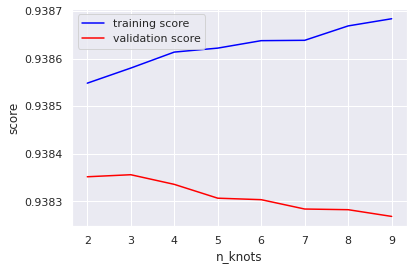

In [24]:
## Now add male * age interaction.

from sklearn.pipeline import FeatureUnion

var_prepro = Pipeline(steps=[('power_tx', PowerTransformer(exponent = 0.5)),
                             ('spline', SplineTransformer(n_knots=5, degree=3))])

prepro = ColumnTransformer([('col_age', var_prepro, ["Age"]),
                            ('col_wt', var_prepro, ["Weight_kg"]),
                            ('col_ht', var_prepro, ["Height_cm"])],
                           remainder = "drop")

## select age and sex, and apply power/spline transformation to age
agesex = ColumnTransformer([('col_age', var_prepro, ["Age"]),
                            ('col_sex', 'passthrough', ["male"])],
                            remainder = "drop")

## second-degree interaction-only polynomial, i.e. just the product of the two inputs
interaction = Pipeline(steps=[('agesex', agesex),
                              ('interact', PolynomialFeatures(degree=(2,2), 
                                                              interaction_only=True))])

## combine the single-variable and interaction features
features = FeatureUnion([('single', prepro),
                         ('interaction', interaction)])

## and build the final pipeline
pipe = Pipeline([('features', features),
                 ('model', LinearRegression())])

## re-name the previously found best parameters
best_params = {}
for bestpars in [best_splines, best_exponents]:
  for key, value in bestpars.items():
    best_params[key.replace('transform', 'features__single')] = value

## copy the exponent for the power transformation of age, from the linear part to the interaction part.
## we could optimize that separately, but hey.
best_params['features__interaction__agesex__col_age__power_tx__exponent'] = best_params["features__single__col_age__power_tx__exponent"]

pipe.set_params( **best_params )

## plot the validation curve for the number of spline knots for the age function in the interaction term
var = 'features__interaction__agesex__col_age__spline__n_knots'
vals = np.arange(2,10,1)

train_score, val_score = validation_curve(pipe, X, y,
                                          param_name = var, 
                                          param_range = vals, 
                                          cv = 5,
                                          scoring = scoremethod)

plt.plot(vals, np.mean (train_score, 1), color='blue', label='training score')
plt.plot(vals, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('n_knots')
plt.ylabel('score');

In [25]:
from sklearn import set_config
set_config(display="display")
print(str(pipe))
pipe

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('single',
                                                 ColumnTransformer(transformers=[('col_age',
                                                                                  Pipeline(steps=[('power_tx',
                                                                                                   PowerTransformer(exponent=0.35000000000000003)),
                                                                                                  ('spline',
                                                                                                   SplineTransformer(n_knots=11))]),
                                                                                  ['Age']),
                                                                                 ('col_wt',
                                                                                  Pipeline(steps=[('power_tx',
                       

Pipeline(steps=[('features',
                 FeatureUnion(transformer_list=[('single',
                                                 ColumnTransformer(transformers=[('col_age',
                                                                                  Pipeline(steps=[('power_tx',
                                                                                                   PowerTransformer(exponent=0.35000000000000003)),
                                                                                                  ('spline',
                                                                                                   SplineTransformer(n_knots=11))]),
                                                                                  ['Age']),
                                                                                 ('col_wt',
                                                                                  Pipeline(steps=[('power_tx',
                       

Best model: mean squared error:  0.004856578477100836


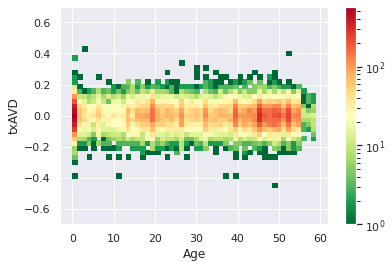

Linear model: mean squared error:  0.006588293886318426


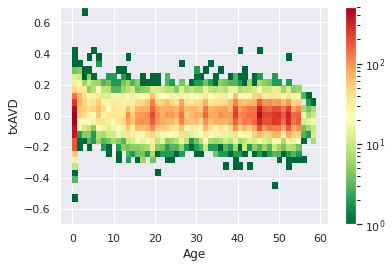

In [26]:
from sklearn.metrics import mean_squared_error

pipe.set_params(features__interaction__agesex__col_age__spline__n_knots = 3)

pipe.fit(X, y)
print("Best model: mean squared error: ",mean_squared_error(y, pipe.predict(X)))

sns.histplot(df, x="Age", y=y-pipe.predict(X), bins=(50,30), 
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )
plt.ylim(-0.7,0.7)
plt.show()

Xlin = df[["Age","Height_cm","Weight_kg","male"]]
ylin = df["txAVD"]
model = LinearRegression()
model.fit(Xlin, ylin)
print("Linear model: mean squared error: ",mean_squared_error(ylin, model.predict(Xlin)))

sns.histplot(df, x="Age", y=ylin-model.predict(Xlin), bins=(50,30),
             cbar=True, cmap="RdYlGn_r", norm=mpl.colors.LogNorm(), vmin=None, vmax=None )
plt.ylim(-0.7,0.7)
plt.show()

In [27]:
from sklearn.linear_model import Ridge

pipe = Pipeline([('features', features),
                 ('model', Ridge(1e-2))])

pipe.set_params( **best_params )
pipe.set_params(features__interaction__agesex__col_age__spline__n_knots = 4)

pipe.fit(X, y)

#scoremethod(pipe, X, y)
pipe.score(X, y)

0.9382999530195645

Text(0, 0.5, 'score')

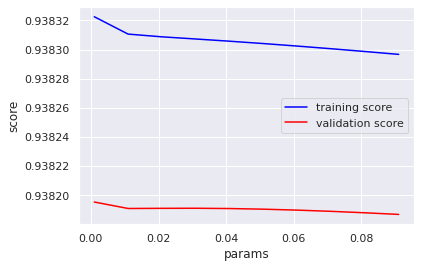

In [28]:
## Regularization does not improve the model:

params = np.arange(1e-3,1e-1,1e-2)
train_score, val_score = validation_curve(pipe, X, y,
                                          param_name = 'model__alpha', 
                                          param_range = params, 
                                          cv = 5,
                                          scoring = scoremethod)

plt.plot(params, np.mean (train_score, 1), color='blue', label='training score')
plt.plot(params, np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
#plt.ylim(-0.004942,-0.004913)
plt.xlabel('params')
plt.ylabel('score')

Text(0, 0.5, 'score')

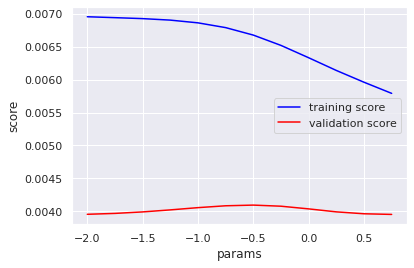

In [29]:
## Now build a model for the standard deviation
## Use the same model structure (but different parameters of course), and re-optimize regularization parameter
## This time, regularization does help

pipe.set_params(model__alpha = 1e-8)   ## set regularization parameter for the standard model
pipe.fit(X, y)
ypred = pipe.predict(X)
residuals = y - ypred
sq_residuals = residuals * residuals

## Fit the same model to the squared residuals - a very noisy target

var_scorer = Make_safe_r2_scorer( sq_residuals )

params = np.power(10, np.arange(-2,1,0.25))
train_score, val_score = validation_curve(pipe, X, sq_residuals,
                                          param_name = 'model__alpha', 
                                          param_range = params, 
                                          cv = 20,
                                          scoring = var_scorer)

from math import log

plt.plot(np.log(params)/log(10), np.mean (train_score, 1), color='blue', label='training score')
plt.plot(np.log(params)/log(10), np.mean(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.xlabel('params')
plt.ylabel('score')

Q values:  [0.051165518252455654, 0.004874651810584958, 0.000623075795337927]
Should be 0.05, 0.0027, 0.00006, if the z scores are truly normally distributed (they are not quite)


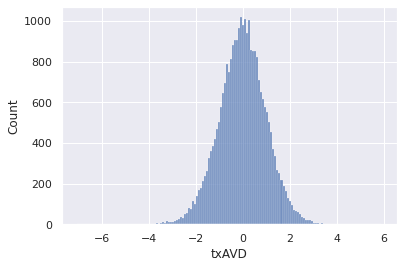

In [31]:
## Now compute Z scores

model = Pipeline([('prepro', ColumnTransformer([("identity", "passthrough", ["Age", "Weight_kg", "Height_cm", "male"])],remainder = "drop")),
                 ('model', LinearRegression())])

model = pipe

## compute predictions - use small alpha
model.set_params(model__alpha = 1e-8)
model.fit(X, y)
y_pred = model.predict( X )

sq_residuals = (y-y_pred) * (y-y_pred)

## set optimal alpha for sd calculation
pipe.set_params(model__alpha = 10 ** -0.5)
model.fit(X, sq_residuals)
sd_pred = np.sqrt( model.predict( X ))

z = (y - y_pred) / sd_pred

sns.histplot(z)

print("Q values: ", list(np.sum( np.abs(z)>zz ) / len(z)
                      for zz in [1.96, 3, 4]))
print("Should be 0.05, 0.0027, 0.00006, if the z scores are truly normally distributed (they are not quite)")